####################################################################################################################
The field has a several oil & gas wells that have been drilled.  These Wells have measurements of the properties of the rocks at various depths.  Each Well will have a different depth for the same formation (rock) due to the nature of the subsurface anomolies.  The location of these Wells and the distance from each other along with the formation tops were used to predict formation top depths at a fresh drilling location.  Regression models were compared and the best performing one was found to be the Linear Regression Model based on the R2-Squared score.  The Model was used to predict the formation top depths at a completely New Location.
####################################################################################################################

In [1183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import os
import math

# Import python library to read las files
import lasio
import geopandas as gpd # For spatial data

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

#from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import LabelEncoder

In [1185]:
# Define the directory containing las files
directory = 'Data'

In [1187]:
# Use glob to get a list of all las files in the directory
las_files = glob.glob(os.path.join(directory, '*.las'))

Create a list of Wells

In [1190]:
# Create an empty dictionary to store the DataFrames for each Well
dataframes = {}

wellsList = []

# Iterate through the list of las files
for files in las_files:
    
    # Extract the filename (without extension) to use as the DataFrame key
    lasName = os.path.splitext(os.path.basename(files))[0]

    # Read the .las file into a pandas DataFrame
    df = lasio.read(files, engine = 'normal').df()

    # Reset index to make 'DEPT' (or equivalent depth curve) a column
    df = df.reset_index().rename(columns={'index': 'DEPTH'})

    # Store the DataFrame in the dictionary with the filename as the key
    dataframes[lasName] = df

    wellsList.append(dataframes[lasName])

Create a function for plotting Gamma Ray and Bulk Density plots

In [1192]:
# Plot the curves for Gamma Ray and Bulk Density
def plots(wellNameDF, wellNameTitle, wellNamePlot):
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
    axes[0].plot(wellNameDF['GR'], wellNameDF['DEPTH'], color="green", label="Gamma Ray")
    axes[0].set_xlim(0, 250)  # Setting x-axis limits for Gamma Ray
    axes[0].set_xlabel("Gamma Ray (GAPI)")
    axes[0].set_title("Gamma Ray")
    axes[0].set_ylabel("True Vertical Depth (M)")
    axes[0].grid(True)

    axes[1].plot(wellNameDF['RHOB'], wellNameDF['DEPTH'], color="red", label="Bulk Density")
    axes[1].set_xlim(1000, 3500)  # Setting x-axis limits
    axes[1].set_xlabel("Bulk Density (K/M3)")
    axes[1].set_title("Bulk Density")
    axes[1].grid(True)

    plt.suptitle(wellNameTitle)
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'Images/{wellNamePlot}', dpi=600)

    # Display the plot
    plt.show()

    return
    

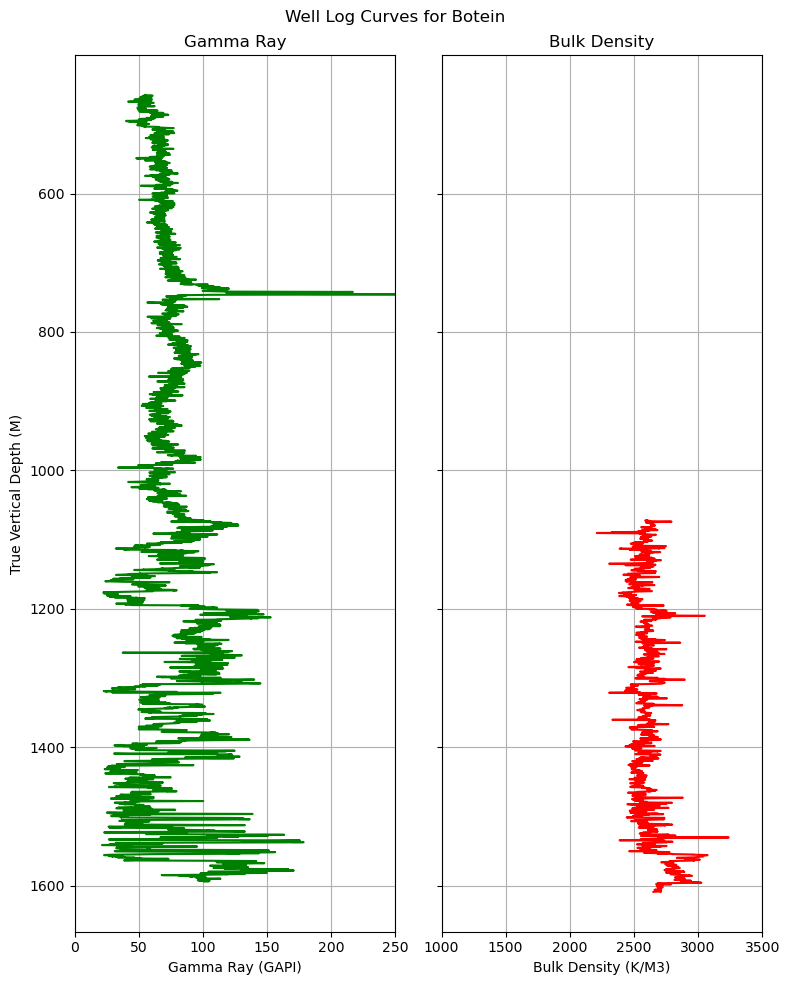

In [1193]:
plots(dataframes['botein'], 'Well Log Curves for Botein', 'gammaRaybulkDensity_Botein')

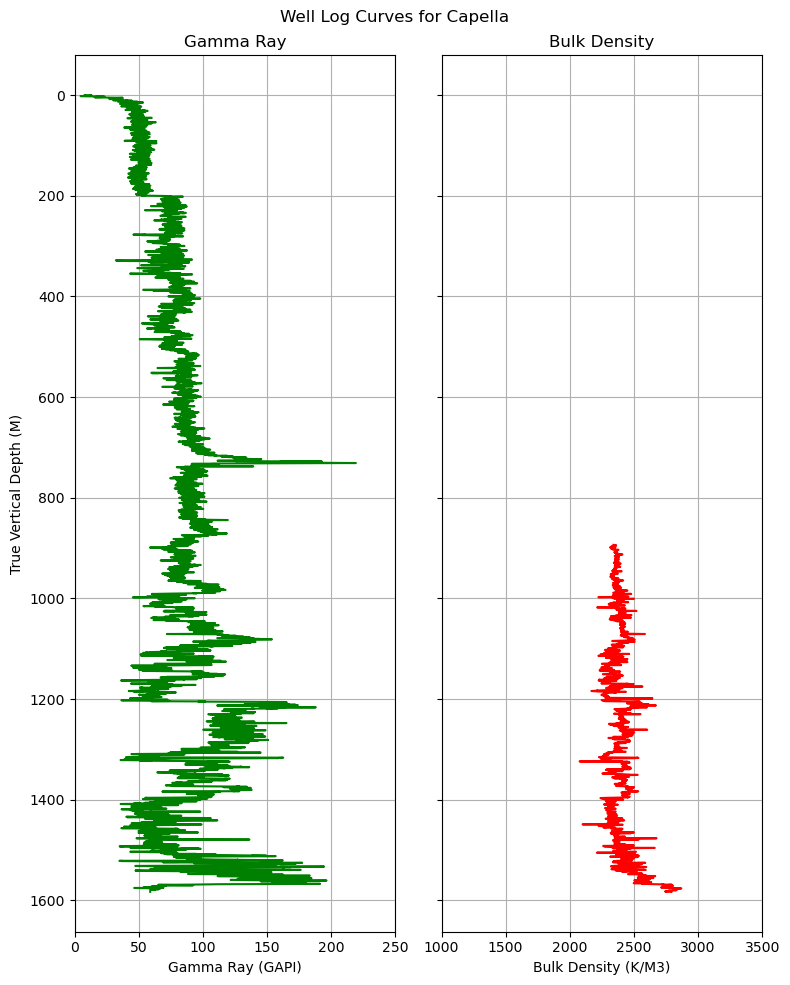

In [1194]:
plots(dataframes['capella'], 'Well Log Curves for Capella', 'gammaRaybulkDensity_Capella')

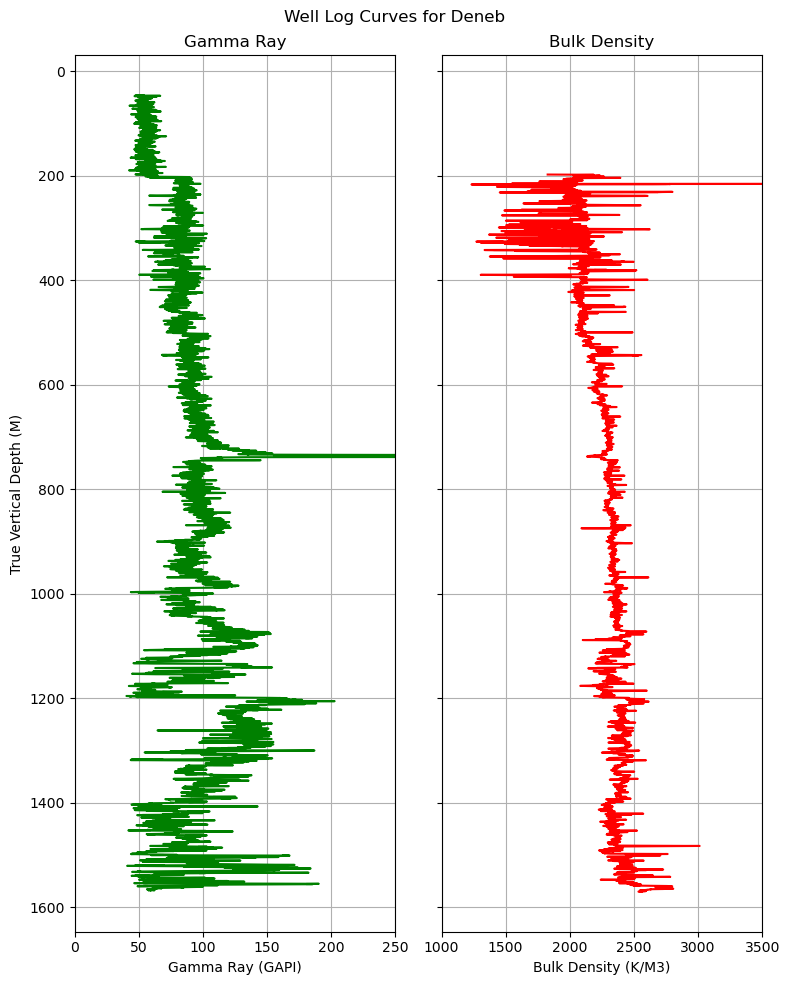

In [1195]:
plots(dataframes['deneb'], 'Well Log Curves for Deneb', 'gammaRaybulkDensity_Deneb')

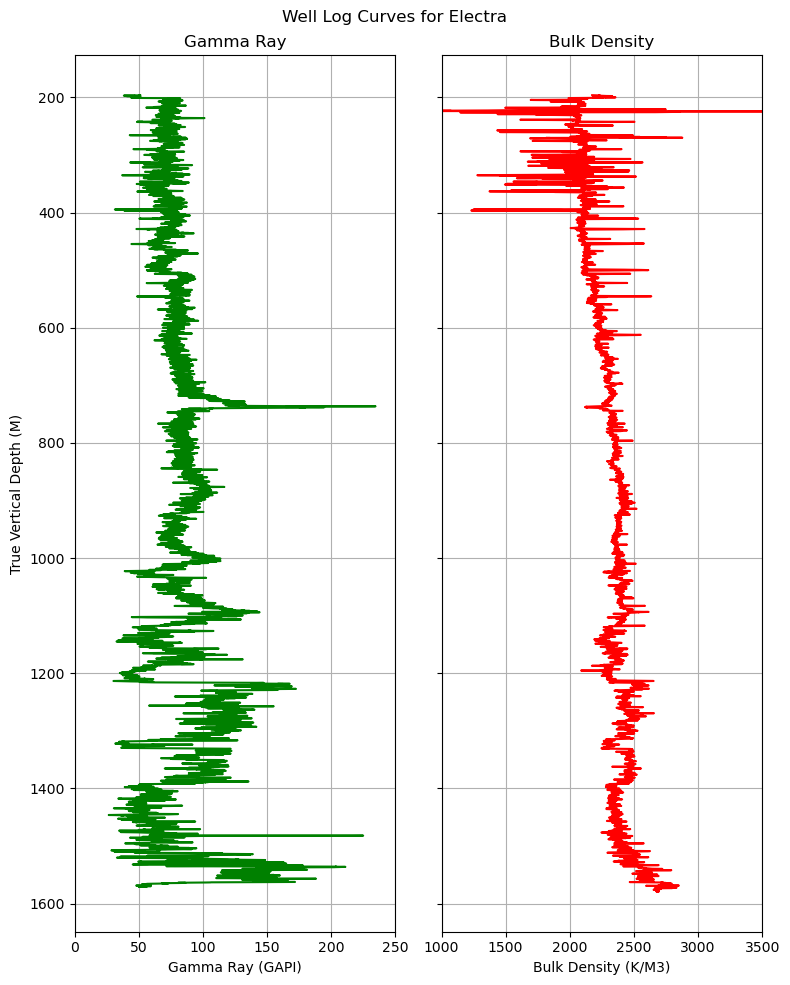

In [1196]:
plots(dataframes['electra'], 'Well Log Curves for Electra', 'gammaRaybulkDensity_Electra')

Extract Well Coordinates from .las file

In [1198]:
#Extract well coordinates
locationDF = pd.DataFrame()

# Define the directory containing las files
directory = 'Data'

# Use glob to get a list of all las files in the directory
las_files = glob.glob(os.path.join(directory, '*.las'))

# Accessing well header parameters
for well in las_files:
    las = lasio.read(well, engine='normal')

    #Well Sirius coordicates are located in the params section of the .las file and the latitude/longitude are in degrees
    if well == "Data\\sirius.las":

        #Convert the latitude from degrees, minutes and seconds to decimal
        degreesLAT = float(las.params['LATI'].value.split(' ')[0])
        minutesLAT = float(las.params['LATI'].value.split(' ')[1][:-1])
        secondsLAT = float(las.params['LATI'].value.split(' ')[2][:-1])
        NS = las.params['LATI'].value.split(' ')[3]

        if NS == 'S':
            latitude = (-1) * (degreesLAT + (minutesLAT / 60) + (secondsLAT / 3600))
        else:
            latitude = (degreesLAT + (minutesLAT / 60) + (secondsLAT / 3600))

        #Convert longitude from degrees, minutes and seconds to decimal
        degreesLONG = float(las.params['LONG'].value.split(' ')[0])
        minutesLONG = float(las.params['LONG'].value.split(' ')[1][:-1])
        secondsLONG = float(las.params['LONG'].value.split(' ')[2][:-1])
        EW = las.params['LONG'].value.split(' ')[3]

        if EW == 'W':
            longitude = (-1) * (degreesLONG + (minutesLONG / 60) + (secondsLONG / 3600))
        else:
            longitude = (degreesLONG + (minutesLONG / 60) + (secondsLONG / 3600))
        
        location = {"Well": well,
                    "Easting": las.params['XREF'].value,
                    "Northing": las.params['YREF'].value,
                    "Latitude": latitude,
                    "Longitude": longitude}

    #The rest of the well data contains the coordinates in the well section of the .las file
    else:
        location = {"Well": well,
                    "Easting": las.well['X'].value,
                    "Northing": las.well['Y'].value,
                    "Latitude": las.well['LATI'].value,
                    "Longitude": las.well['LONG'].value}

    # create a dataframe and append the location summary to it        
    Location = pd.concat([locationDF, pd.DataFrame([location])])

    # Remove the specific text "Data", "\" and ".las" from 'Well' column
    Location['Well'] = Location['Well'].str.replace('Data', '', regex=False)
    Location['Well'] = Location['Well'].str.replace('\\', '', regex=False)
    Location['Well'] = Location['Well'].str.replace('.las', '', regex=False)

    locationDF = Location

In [1199]:
locationDF

,Well,Easting,Northing,Latitude,Longitude
0,atlas,6.535239e+05,8.158308e+06,-16.652679,154.439550
0,botein,6.525877e+05,8.157412e+06,-16.660833,154.430833
0,capella,6.529543e+05,8.157948e+06,-16.655965,154.434234
0,deneb,6.523907e+05,8.156956e+06,-16.664967,154.429017
0,electra,2.143052e+06,2.676807e+07,-16.647284,154.436493
0,furud,6.537720e+05,8.157280e+06,-16.661944,154.441944
0,gomeisa,6.528013e+05,8.158686e+06,-16.649306,154.432750
0,heze,6.530609e+05,8.157286e+06,-16.661944,154.435278
0,izar,6.536344e+05,8.158757e+06,-16.648611,154.440556
0,kraz,6.539292e+05,8.158540e+06,-16.650556,154.443333


Plot an interactive map of the Well locations

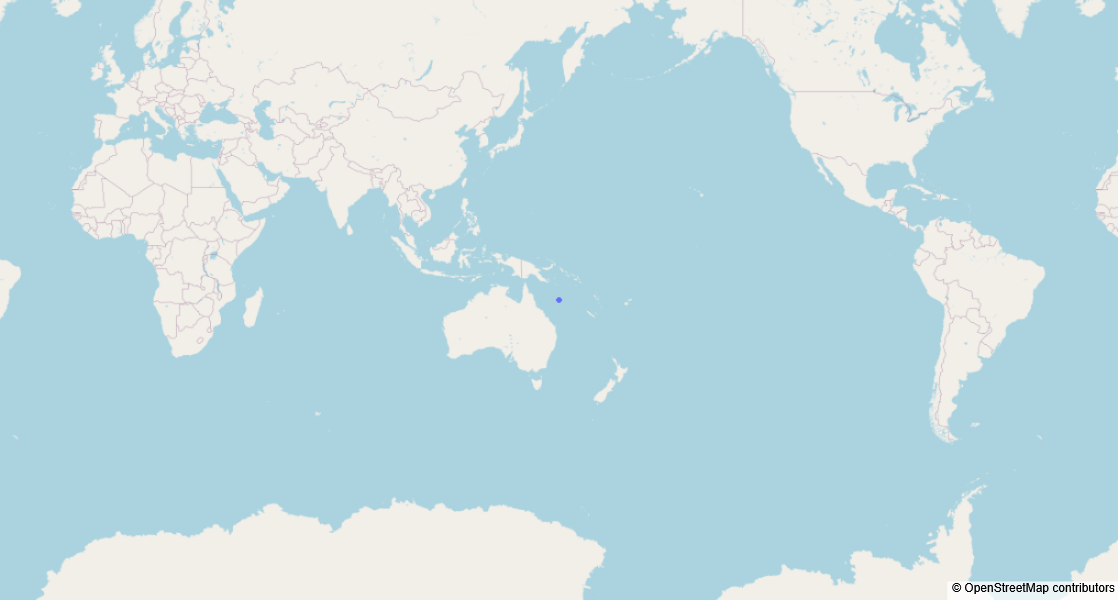

In [1258]:
import plotly.express as px

# Create a scatter mapbox plot of the Well locations
fig = px.scatter_mapbox(locationDF, lat="Latitude", lon="Longitude", hover_name="Well", zoom=1, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

Compute distance between each Well in the field

In [1203]:
#function to calculate distances between all the Wells in the field
def locationData(locations):
    
    #initialize empty dataframe
    location = pd.DataFrame()
   
    for i in range(len(locations)):
        
        for j in range(len(locations)):
        
            well = locations['Well'].iloc[i]
            easting = locations['Easting'].iloc[i]
            northing = locations['Northing'].iloc[i]
            latitude = locations['Latitude'].iloc[i]
            longitude = locations['Longitude'].iloc[i]

            #Distance between two Wells
            delta_easting = locations['Easting'].iloc[i] - locations['Easting'].iloc[j]
            delta_northing = locations['Northing'].iloc[i] - locations['Northing'].iloc[j]
            distance = math.sqrt(delta_easting**2 + delta_northing**2)

            summary = {
                'Well': well,
                'Easting': easting,
                'Northing': northing,
                'Latitude': latitude,
                'Longitude': longitude,
                f'Distance_from_{locations['Well'].iloc[j]}': distance,
            }

            Summary = pd.DataFrame([summary])

            wellLocation = pd.concat([location, Summary])
        
            location = wellLocation
        
            #flatten the dataframe
            wellDistance = location.groupby('Well').first().reset_index()
            wellDistance = wellDistance.set_index('Well')
            

    return wellDistance

In [1206]:
wellDistance

,Well,Easting,Northing,Latitude,Longitude,Distance_from_atlas,Distance_from_botein,Distance_from_capella,Distance_from_deneb,Distance_from_electra,Distance_from_furud,Distance_from_gomeisa,Distance_from_heze,Distance_from_izar,Distance_from_kraz,Distance_from_sirius,Distance_from_talitha
0,atlas,6.535239e+05,8.158308e+06,-16.652679,154.4325,0.000000e+00,1.295654e+03,6.736861e+02,1.763853e+03,1.866928e+07,1.056634e+03,8.157490e+02,1.122009e+03,4.626894e+02,4.669639e+02,1.866658e+07,2.404717e+02
1,botein,6.525877e+05,8.157412e+06,-16.660833,154.4325,1.295654e+03,0.000000e+00,6.493910e+02,4.967219e+02,1.867024e+07,1.191514e+03,1.291870e+03,4.897450e+02,1.704272e+03,1.752480e+03,1.866755e+07,1.362645e+03
2,capella,6.529543e+05,8.157948e+06,-16.655965,154.4325,6.736861e+02,6.493910e+02,0.000000e+00,1.140937e+03,1.866968e+07,1.055561e+03,7.537235e+02,6.709262e+02,1.056868e+03,1.140394e+03,1.866699e+07,7.976084e+02
3,deneb,6.523907e+05,8.156956e+06,-16.664967,154.4325,1.763853e+03,4.967219e+02,1.140937e+03,0.000000e+00,1.867071e+07,1.418885e+03,1.778123e+03,7.468791e+02,2.188672e+03,2.207923e+03,1.866802e+07,1.800146e+03
4,electra,2.143052e+06,2.676807e+07,-16.647284,154.4325,1.866928e+07,1.867024e+07,1.866968e+07,1.867071e+07,0.000000e+00,1.867028e+07,1.866896e+07,1.867033e+07,1.866882e+07,1.866901e+07,2.951348e+03,1.866940e+07
5,furud,6.537720e+05,8.157280e+06,-16.661944,154.4325,1.056634e+03,1.191514e+03,1.055561e+03,1.418885e+03,1.867028e+07,0.000000e+00,1.708151e+03,7.110910e+02,1.482806e+03,1.268905e+03,1.866759e+07,8.901831e+02
6,gomeisa,6.528013e+05,8.158686e+06,-16.649306,154.4325,8.157490e+02,1.291870e+03,7.537235e+02,1.778123e+03,1.866896e+07,1.708151e+03,0.000000e+00,1.424294e+03,8.361630e+02,1.137369e+03,1.866626e+07,1.054630e+03
7,heze,6.530609e+05,8.157286e+06,-16.661944,154.4325,1.122009e+03,4.897450e+02,6.709262e+02,7.468791e+02,1.867033e+07,7.110910e+02,1.424294e+03,0.000000e+00,1.579142e+03,1.525286e+03,1.866764e+07,1.102689e+03
8,izar,6.536344e+05,8.158757e+06,-16.648611,154.4325,4.626894e+02,1.704272e+03,1.056868e+03,2.188672e+03,1.866882e+07,1.482806e+03,8.361630e+02,1.579142e+03,0.000000e+00,3.661859e+02,1.866612e+07,5.939957e+02
9,kraz,6.539292e+05,8.158540e+06,-16.650556,154.4325,4.669639e+02,1.752480e+03,1.140394e+03,2.207923e+03,1.866901e+07,1.268905e+03,1.137369e+03,1.525286e+03,3.661859e+02,0.000000e+00,1.866632e+07,4.251262e+02


Extract rock Formation Tops for each well

In [1208]:
# Formation tops list of files from folder
formationDF = pd.DataFrame()
formationTops_list = []

for item in os.listdir('Data'):
    item_path = os.path.join('Data', item)
    if os.path.isfile(item_path) and item.endswith('.txt'):
        formationTops_list.append(item)

for name in formationTops_list:
    well = pd.read_csv('Data/'+name, sep='[|,]', engine = 'python')
    well.columns=['DEPTH', 'FORMATION']
    
    if name == 'atlasFormationTops.txt':
        # Replace 'DALWOOD GROUP' with 'Dalwood Group' only in column
        well['FORMATION'] = well['FORMATION'].replace('DALWOOD GROUP', 'Dalwood Group')
        
    elif name == 'boteinFormationTops.txt':
        #drop last row as it is duplicate
        well.drop(well.tail(1).index, inplace=True)
        #boteinFormationdf.drop(boteinFormationdf.tail(1).index, inplace=True)

    elif name == 'electraFormationTops.txt':
        #convert from feet to meters
        well['DEPTH'] = well['DEPTH'] * 0.3048

    for index, row in well.iterrows():
        summary = {
            "Well": name,
            "Depth": row['DEPTH'],
            "Formation": row['FORMATION']}
        
        # create a dataframe and append the summary to it        
        formation = pd.concat([formationDF, pd.DataFrame([summary])])
        
        # Remove the specific text "FormationTops.txt" from 'Well' column
        formation['Well'] = formation['Well'].str.replace('FormationTops.txt', '', regex=False)
        
        formationDF = formation

In [1209]:
formationDF

,Well,Depth,Formation
0,atlas,4.6619,Doyles Creek Subgroup
0,atlas,435.4607,Horseshoe Creek Subgroup
0,atlas,514.1221,Apple Tree Flat Subgroup
0,atlas,732.2914,Watts Sandstone
0,atlas,743.8090,Denman Fm
...,...,...,...
0,talitha,1193.5000,Mt Thorley Fm
0,talitha,1253.5000,Burnamwood Fm
0,talitha,1351.5000,Archerfield Sandstone
0,talitha,1381.0000,Mulbring Siltstone


In [1211]:
#Merge the formation tops and coordinates
wellFormationTops = pd.merge(wellDistance,formationDF, on='Well', how='inner')

In [1212]:
# Testing different regression models

modelDF = pd.DataFrame()

# Define features (X) and target (y)
X = wellFormationTops[['Easting', 'Northing', 'Formation', 'Distance_from_atlas', 'Distance_from_botein',
                       'Distance_from_capella', 'Distance_from_deneb', 'Distance_from_electra',
                       'Distance_from_furud', 'Distance_from_gomeisa', 'Distance_from_heze',
                       'Distance_from_izar', 'Distance_from_kraz', 'Distance_from_sirius', 'Distance_from_talitha']]

y = wellFormationTops['Depth']

#Models to evaluate, KNN (use 5 as K value), Linear Regression, Decision Tree Regressor, SVM, Ridge, RandomForestRegressor
regressor = ['LinearRegression', 'KNeighborsRegressor', 'DecisionTreeRegressor', 'SVR', 'Ridge', 'RandomForestRegressor']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building a preprocessing pipeline
numericalCols = X.select_dtypes(include=['int64', 'float64']).columns
categoricalCols = X.select_dtypes(include=['object']).columns

#define separate pipelines for numerical and categorical features.
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numericalCols),
                  ('cat', OneHotEncoder(handle_unknown='ignore'), categoricalCols)])

for name in regressor:

    if name == 'LinearRegression':
        model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
        
    elif name == 'KNeighborsRegressor':
        model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', KNeighborsRegressor(n_neighbors=6))])

    elif name == 'DecisionTreeRegressor':
        model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(max_depth=4, random_state=42))])

    elif name == 'SVR':
        model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1))])
              
    elif name == 'Ridge':
        model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])

    elif name == 'RandomForestRegressor':
        model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
   
    r2_score_from_function = r2_score(y_test, y_pred)

    mse = mean_squared_error(y_test, y_pred)

    mae = mean_absolute_error(y_test, y_pred)


    modelSummary = {
        "Model": name,
        "R-Squared": r2_score_from_function,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae
    }
        
    # create a dataframe and append the summary to it        
    summary = pd.concat([modelDF, pd.DataFrame([modelSummary])], ignore_index=True)
        
    modelDF = summary

# Get the row with the maximum R-Squared
max_R2 = modelDF['R-Squared'].max()

# Styling function to highlight rows where 'R-Squared' is maximum value
def highlight_R2(row):
    if row['R-Squared'] == max_R2:
        return ['background-color: lightcoral'] * len(row)
    else:
        return [''] * len(row)

# Apply the styling
model_df = modelDF.style.apply(highlight_R2, axis=1)

# Display the styled DataFrame 
model_df

,Model,R-Squared,Mean Squared Error,Mean Absolute Error
0,LinearRegression,0.997424,338.887128,13.022803
1,KNeighborsRegressor,0.898833,13309.294953,69.296410
2,DecisionTreeRegressor,0.686165,41287.347990,151.975396
3,SVR,0.359089,84316.729610,213.745659
4,Ridge,0.982090,2356.142208,41.229419
5,RandomForestRegressor,0.997325,351.869918,14.477995


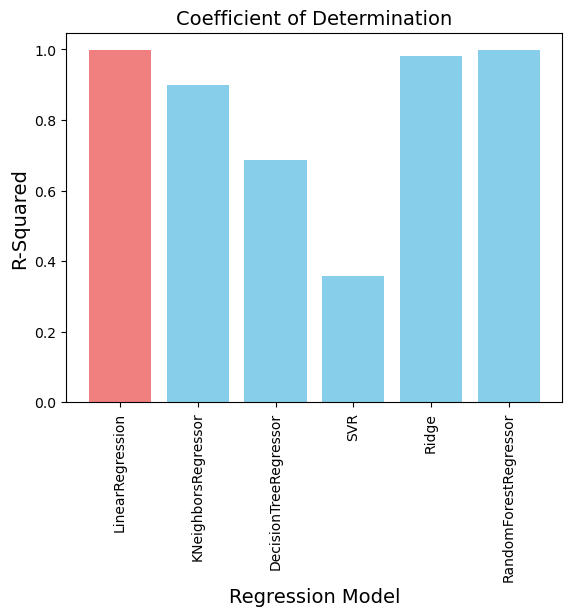

In [1213]:
#Plot Model used vs R-Squared
max_value_index = np.argmax(modelDF['R-Squared'])
colors = ['skyblue'] * len(modelDF['Model'])  # Default color for all bars
colors[max_value_index] = 'lightcoral'  # Highlight the maximum bar

# Create a vertical bar chart
plt.bar(modelDF['Model'], modelDF['R-Squared'], color=colors)
# Rotate the x-axis labels vertically
plt.xticks(rotation='vertical')
plt.xlabel('Regression Model', fontsize=14)
plt.ylabel('R-Squared', fontsize=14)
plt.title('Coefficient of Determination', fontsize=14)
# Save the plot
plt.savefig('Images/coeffDetermination', dpi=600)
plt.show()

Testing the Model with input data for New_Well

In [1241]:
#Input new Well location (Easting and Northing) for testing the model

well = 'New_Well'
easting = input("Easting: ") # use 653523.946071 which are coordinates for Atlas Well
northing = input("Northing: ") # 8158308.615707 which are coordinates for Atlas Well
latitude = input("Latitude: ") # 0 as this is not used except for mapping
longitude = input("Longitude: ") #  0 as this is not used except for mapping

Easting:  653523
Northing:  8158308
Latitude:  0
Longitude:  0


In [1243]:
# New rows to add to calculate distance between each Well to the New_Well

Easting = float(easting)
Northing = float(northing)
Latitude = float(latitude)
Longitude = float(longitude)

newWellData = {'Well': well,
               'Easting': Easting,
               'Northing': Northing,
               'Latitude': Latitude,
               'Longitude': Longitude
              }

new_well = pd.DataFrame(newWellData, index=[0])

# Concatenate vertically (default axis=0)
newLocations = pd.concat([locationDF, new_well])

In [1245]:
#Use fuction with the New_Well location to calculate the distances between each Well
newWellDistance = locationData(newLocations)

In [1246]:
#Recreate dataframe from New_Well data

# Convert the 'Formation' column to a list
formation_list = formationDF['Formation'].unique()

#Create a well list containing only 'New_Well' for the same number of rows as the formations
well_list = ['New_Well'] * len(formation_list)

# Create the DataFrame with the New Well and the formations
newWellFormation = pd.DataFrame({'Well': well_list, 'Formation': formation_list})

#Contatenate the wells and the formations to the New Well and the formations 
newFormationDF = pd.concat([formationDF, newWellFormation])

# Concatenate newWellDistance to wellFormationTops and create a new DataFrame
newWellFormationTops = pd.merge(newWellDistance, newFormationDF, on='Well', how='inner')

#########################################################################################################

Predict Formation Top depths for the New_Well using the regression model with the best R2_Squared (Linear Regression).

#########################################################################################################

In [1250]:
#Create empty dataframe

FormationPredictionDF = pd.DataFrame()

df_train = newWellFormationTops.dropna(subset=['Depth'])
df_predict = newWellFormationTops[newWellFormationTops['Depth'].isna()]

X_train = df_train[['Easting', 'Northing', 'Formation', 'Distance_from_atlas', 'Distance_from_botein',
                    'Distance_from_capella', 'Distance_from_deneb', 'Distance_from_electra',
                    'Distance_from_furud', 'Distance_from_gomeisa', 'Distance_from_heze',
                    'Distance_from_izar', 'Distance_from_kraz', 'Distance_from_sirius',
                    'Distance_from_talitha', 'Distance_from_New_Well']]

y_train = df_train['Depth']

# Building a preprocessing pipeline
numericalCols = X.select_dtypes(include=['int64', 'float64']).columns
categoricalCols = X.select_dtypes(include=['object']).columns

#define separate pipelines for numerical and categorical features.
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numericalCols),
                  ('cat', OneHotEncoder(handle_unknown='ignore'), categoricalCols)])

model = Pipeline(steps=[('preprocessor', preprocessor), ('LinearRegression', LinearRegression())])


model.fit(X_train, y_train)

X_predict = df_predict[['Easting', 'Northing', 'Formation', 'Distance_from_atlas', 'Distance_from_botein',
                        'Distance_from_capella', 'Distance_from_deneb', 'Distance_from_electra',
                        'Distance_from_furud', 'Distance_from_gomeisa', 'Distance_from_heze',
                        'Distance_from_izar', 'Distance_from_kraz', 'Distance_from_sirius',
                        'Distance_from_talitha', 'Distance_from_New_Well']]
    
predicted_values = model.predict(X_predict)

newWellFormationTops.loc[newWellFormationTops['Depth'].isna(), 'Depth'] = predicted_values

FormationPredictionDF = pd.concat([FormationPredictionDF, newWellFormationTops], ignore_index=True)

In [1252]:
FormationPredictionDF

,Well,Easting,Northing,Latitude,Longitude,Distance_from_atlas,Distance_from_botein,Distance_from_capella,Distance_from_deneb,Distance_from_electra,Distance_from_furud,Distance_from_gomeisa,Distance_from_heze,Distance_from_izar,Distance_from_kraz,Distance_from_sirius,Distance_from_talitha,Distance_from_New_Well,Depth,Formation
0,New_Well,653523.000000,8.158308e+06,0.000000,0.000000,1.021142,1295.236082,673.091711,1763.540149,1.866928e+07,1057.230035,814.732668,1121.969047,462.543311,467.594673,1.866658e+07,241.466688,0.000000,0.761730,Doyles Creek Subgroup
1,New_Well,653523.000000,8.158308e+06,0.000000,0.000000,1.021142,1295.236082,673.091711,1763.540149,1.866928e+07,1057.230035,814.732668,1121.969047,462.543311,467.594673,1.866658e+07,241.466688,0.000000,431.011129,Horseshoe Creek Subgroup
2,New_Well,653523.000000,8.158308e+06,0.000000,0.000000,1.021142,1295.236082,673.091711,1763.540149,1.866928e+07,1057.230035,814.732668,1121.969047,462.543311,467.594673,1.866658e+07,241.466688,0.000000,504.315473,Apple Tree Flat Subgroup
3,New_Well,653523.000000,8.158308e+06,0.000000,0.000000,1.021142,1295.236082,673.091711,1763.540149,1.866928e+07,1057.230035,814.732668,1121.969047,462.543311,467.594673,1.866658e+07,241.466688,0.000000,731.795623,Watts Sandstone
4,New_Well,653523.000000,8.158308e+06,0.000000,0.000000,1.021142,1295.236082,673.091711,1763.540149,1.866928e+07,1057.230035,814.732668,1121.969047,462.543311,467.594673,1.866658e+07,241.466688,0.000000,745.704038,Denman Fm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,talitha,653720.586786,8.158169e+06,-16.653917,154.441403,240.471749,1362.645338,797.608358,1800.146291,1.866940e+07,890.183061,1054.630048,1102.689246,593.995742,425.126229,1.866670e+07,0.000000,241.466688,1193.500000,Mt Thorley Fm
198,talitha,653720.586786,8.158169e+06,-16.653917,154.441403,240.471749,1362.645338,797.608358,1800.146291,1.866940e+07,890.183061,1054.630048,1102.689246,593.995742,425.126229,1.866670e+07,0.000000,241.466688,1253.500000,Burnamwood Fm
199,talitha,653720.586786,8.158169e+06,-16.653917,154.441403,240.471749,1362.645338,797.608358,1800.146291,1.866940e+07,890.183061,1054.630048,1102.689246,593.995742,425.126229,1.866670e+07,0.000000,241.466688,1351.500000,Archerfield Sandstone
200,talitha,653720.586786,8.158169e+06,-16.653917,154.441403,240.471749,1362.645338,797.608358,1800.146291,1.866940e+07,890.183061,1054.630048,1102.689246,593.995742,425.126229,1.866670e+07,0.000000,241.466688,1381.000000,Mulbring Siltstone
